<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/test_correlation_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setting up the environment**

In [7]:
import os, sys
import os.path as osp
from google.colab import drive, files
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [8]:
import time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from collections import Counter
from torch_geometric.utils import to_dense_adj
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_theme(font_scale=1.8)
sns.set_style("white")

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset
path = osp.join(os.getcwd(), 'data')

## **Utility functions**

In [9]:
def hop_neighbors(k:int, dense_adj: torch.Tensor):
    cum_neighbors = pow_A = dense_adj.clone()

    yield dense_adj, dense_adj

    for _ in range(k-1):
        pow_A = torch.mm(dense_adj, pow_A)
        neighbors = torch.where(
            (torch.clamp(pow_A, max=1, min=0) - cum_neighbors) > 0,
            1, 0)
        cum_neighbors += neighbors
        
        yield neighbors, cum_neighbors

In [10]:
def scale(X:torch.Tensor):   
    m = X.mean(0)
    s = X.std(0)
    ones = torch.ones(s.shape, device=device)
    s = torch.where(s == 0, ones, s)
    return (X - m)/ s

In [11]:
def centroids(X:torch.Tensor, y:torch.Tensor):
    num_classes = y.max().item() + 1
    
    # group nodes by label
    obs = {}
    for i in range(X.size(0)):
        if obs.get(y[i].item()):
            obs[y[i].item()] += [X[i]]
        else:
            obs[y[i].item()] = [X[i]]

    return torch.stack([sum(obs[c]) / len(obs[c]) for c in range(num_classes)], 0)

In [41]:
def corrcoef(x: torch.Tensor, y: torch.Tensor):
    """Mimics `np.corrcoef`
    Args
        - x: 2D torch.Tensor
        - y: 1D torch.Tensor
    Returns
        c : torch.Tensor
    """
    if x == [] or x.size(0) == 0:
        return torch.tensor(0., device=device)

    # calculate covariance matrix of rows
    # mean_x = x.mean(1).unsqueeze(1).expand(x.shape)  # [num_nodes]
    # mean_y = y.mean()  # (1)
    cov = torch.matmul(x.sub(x.mean(1, keepdim=True)), y.sub(y.mean()).t()) / y.size(0)

    # normalize covariance by standard deviation
    cov /= x.std(1) * y.std()

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    return torch.clamp(cov, -1.0, 1.0)


def graph_correlation_1(neb: torch.Tensor, x: torch.Tensor, y: torch.Tensor):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.
    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node
    :rtype: list [num_nodes]: correlation (scalar) for every node
    """
    num_nodes = x.size(0)
    return torch.stack([corrcoef(x=x[neb[i] == 1], y=y[i]).abs().mean().to(device) for i in range(num_nodes)], 0)

In [13]:
def corr(x, y, i):
    if x.size(0) == 0: return torch.tensor(0., device=device)
    cov = torch.einsum('ij, j -> i', x, y)
    norm = torch.mm(x, x.t()).diag().sqrt() * torch.matmul(y, y).sqrt()
    return cov / norm

def graph_correlation_2(neb:torch.Tensor, x:torch.Tensor, y:torch.Tensor, y_mean:torch.Tensor):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node
        :rtype: list [num_nodes]: correlation (scalar) for every node
    """

    num_nodes = x.size(0)
    y_scaled = y.sub(y_mean)

    return torch.stack([corr(x=x[neb[i] == 1], y=y_scaled[i], i=i).abs().mean() for i in range(num_nodes)], 0)

In [176]:
def pre_processing(graph, scaled=True): 
    if scaled:
        x = scale(graph.x)
    else:
        x = graph.x
    
    scaled_centroids = centroids(x, graph.y) # $Y_l \forall l \in [0, 6]$
    y = torch.stack([scaled_centroids[graph.y[i]] for i in range(graph.num_nodes)]) # $Y_v \forall v \in \mathcal V$
    y_mean = scaled_centroids.mean(0) # $\bar Y$

    return x, y, y_mean, scaled_centroids

In [187]:
def plot_summary(data, title="Correlation"):
    plt.figure(figsize=(10,10))
    
    lineplot = sns.lineplot(x='k', y='value',
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'corr_1', 'corr_2']], ['k']))
    lineplot.set(xlabel="depth", ylabel="count", title=title)
    lineplot.legend(('rho_1', 'rho_2'), loc="best", frameon=False).set_title(None)

In [174]:
def run(graph, scaled=True, depth=10):
    x, y, y_mean, _ = pre_processing(graph, scaled=scaled)
    dense_adj = to_dense_adj(graph.edge_index).squeeze(0)

    data = pd.DataFrame({
        'k':[],
        'corr_1':[],
        'corr_2':[]
    })
    k = idx = 0
    for neighbors, _ in tqdm(hop_neighbors(depth, dense_adj), total=depth):
        k+=1
        corr_1 = graph_correlation_1(neighbors, x, y)
        corr_2 = graph_correlation_2(neighbors, x, y, y_mean)
        data.loc[idx] = {'k':k, 'corr_1':corr_1.mean().item(), 'corr_2':corr_2.mean().item()}
        idx+=1
    
    return data

## **Experiments**

\begin{equation}
    \rho_1 = \frac{ \tilde X_u - \bar{\tilde X_u} }{ \lVert \tilde X_u - \bar{\tilde X_u} \rVert  } \cdot \frac{ (Y_v - \bar Y_v)^T }{ \lVert Y_v - \bar Y_v \rVert }
    \tag{1}
\end{equation}

\begin{equation}
    \rho_2 = \frac{ \tilde X_u - \bar X }{ \lVert \tilde X_u - \bar X \rVert  } \cdot \frac{ (Y_v - \bar Y)^T }{ \lVert Y_v - \bar Y \rVert }
    \tag{2}
\end{equation}



1. $\bar X = 0$ because $X$ is scaled at the very beginning.
2. $\bar Y_v \approx 0$
2. $\bar {\tilde X_u} \approx 0$
3. If we don't scale $X$ we end up with significantly different values.

\begin{equation}
    \rho_1 = \frac{ \tilde X_u }{ \lVert \tilde X_u \rVert  } \cdot \frac{ Y_v^T }{ \lVert Y_v \rVert }
\end{equation}

\begin{equation}
    \rho_2 = \frac{ \tilde X_u }{ \lVert \tilde X_u \rVert  } \cdot \frac{ (Y_v - \bar Y)^T }{ \lVert Y_v - \bar Y \rVert }
\end{equation}

In [69]:
cora = load_dataset(path, 'Cora')
graph = cora[0]

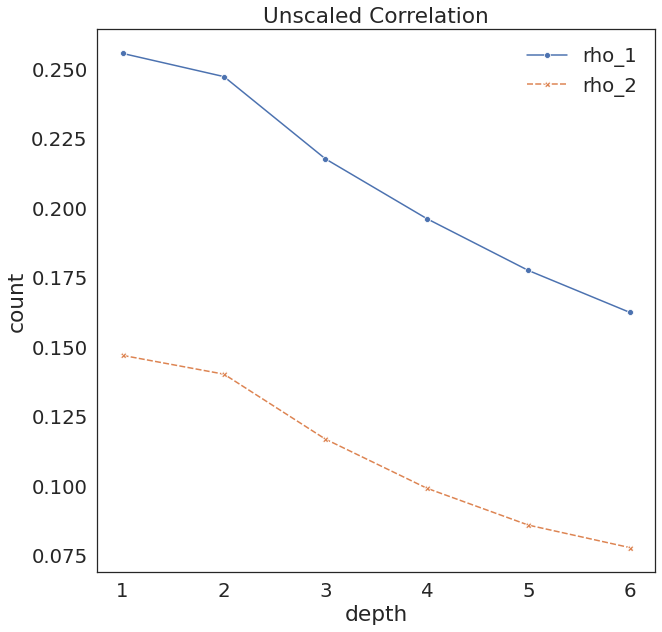

In [188]:
unscaled_corr = run(graph, scaled=False, depth=6)
plot_summary(unscaled_corr, title="Unscaled Correlation")

The unscaled correlation is not as expressive as before (with regards to problem radius).

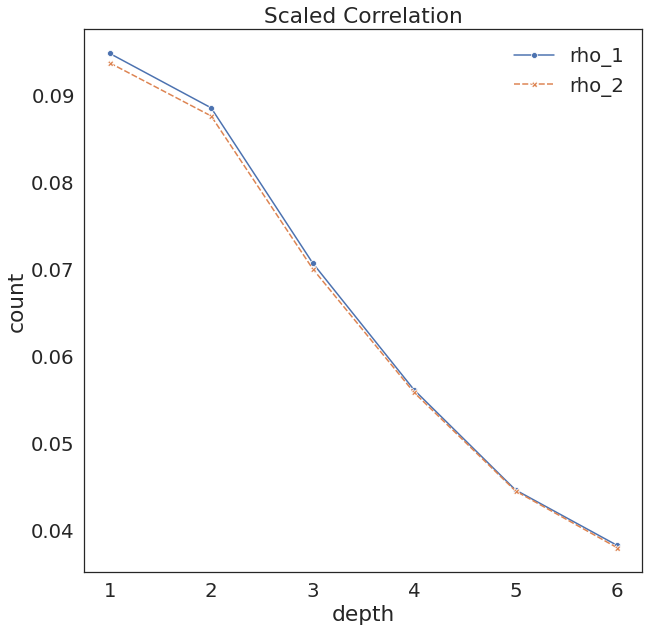

In [189]:
scaled_corr = run(graph, scaled=True, depth=6)
plot_summary(scaled_corr, title="Scaled Correlation")

In [84]:
y.mean(1)

tensor([-0.0004,  0.0026,  0.0026,  ..., -0.0004, -0.0004, -0.0004])

In [83]:
x_scaled = scale(graph.x)

In [86]:
x_scaled.mean(1, keepdim=True)

tensor([[-0.0522],
        [ 0.0139],
        [-0.0205],
        ...,
        [-0.0046],
        [-0.0069],
        [-0.0233]])

In [141]:
x.mean(1) * np.sqrt(graph.num_nodes)

tensor([-2.7172,  0.7213, -1.0644,  ..., -0.2380, -0.3595, -1.2137])

In [154]:
torch.norm(x.mean(1, keepdim=True).expand(-1, graph.num_nodes), dim=1) == ((x.mean(1) * np.sqrt(graph.num_nodes)).abs()

tensor([2.7172, 0.7213, 1.0644,  ..., 0.2380, 0.3595, 1.2137])

In [161]:
((x.mean(1) * np.sqrt(graph.num_nodes)).abs() / torch.norm(x, dim=1)).mean()

tensor(0.0517)

$$
\mathbb E \left[ \frac{\lVert \bar{\tilde X_u} \rVert}{ \lVert \tilde X_u \rVert } \right] = 0.0517
$$

In [170]:
(y_mean.norm() / y.norm(dim=1)).mean()

tensor(0.2273)

$$
\mathbb E \left[ \frac{\lVert \bar{\bar Y} \rVert}{ \lVert Y_v \rVert } \right] = 0.2273
$$

$$
\bar Y_v \approx 0
$$

In [126]:
y.mean(1)

tensor([-0.0004,  0.0026,  0.0026,  ..., -0.0004, -0.0004, -0.0004])

$$\bar X = 0$$

In [131]:
x.mean(0)

tensor([-7.0434e-09, -3.1695e-09, -2.3243e-08,  ...,  3.5217e-09,
        -3.3808e-08, -6.8673e-09])

### **CiteSeer**

In [46]:
citeseer = load_dataset(path, 'CiteSeer')
graph = citeseer[0]

data = run(graph)

Processing...
Done!


  0%|          | 0/10 [00:00<?, ?it/s]

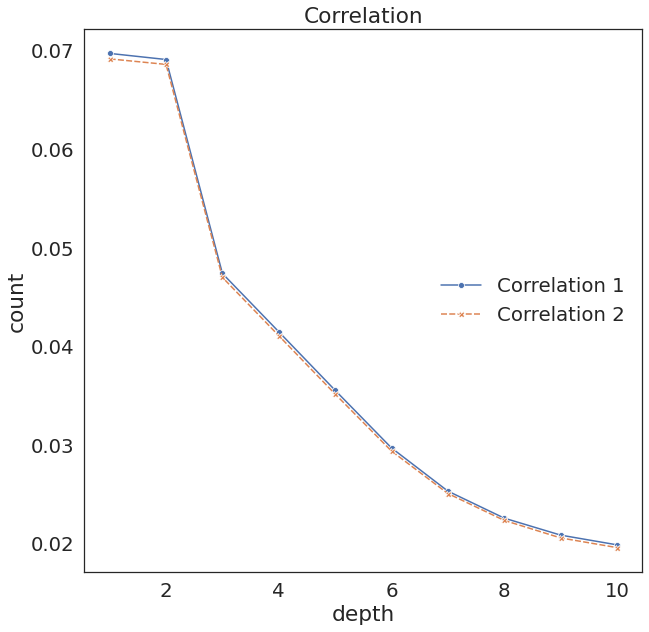

In [48]:
plot_summary(data)